=====DATSCIW261 ASSIGNMENT #7=====


MIDS UC Berkeley, Machine Learning at Scale

DATSCIW261 ASSIGNMENT #9

#### Hetal Chandaria (hetalchandaria@berkeley.edu) 

W261 - 2 , ASSIGNMENT #9

Submission Date : 

Group : 4

### ===HW 9.0: Short answer questions===

What is PageRank and what is it used for in the context of web search?

What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to 
compute the steady stade distibuton?

OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

<h2><span style="color: blue"> Answer </span></h2>
<li>
<span style="color: blue"> What is PageRank and what is it used for in the context of web search? </span> </li><li>
<span style="color: blue"> What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to compute the steady stade distibuton?</span></li><li>
<span style="color: blue"> OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)</span></li>
</li>





In [35]:
%matplotlib inline

### ===HW 9.1: MRJob implementation of basic PageRank===

Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).
Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]


As you build your code, use the test data

s3://ucb-mids-mls-networks/PageRank-test.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name. 
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

with teleportation parameter set to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck
your work with the true result, displayed in the first image
in the Wikipedia article:

https://en.wikipedia.org/wiki/PageRank

and here for reference are the corresponding PageRank probabilities:

A,0.033

B,0.384

C,0.343

D,0.039

E,0.081

F,0.039

G,0.016

H,0.016

I,0.016

J,0.016

K,0.016



<h2><span style="color: blue"> Answer </span></h2>

Implementation approach:

1. First we will do data analysis to determine the number of nodes
2. Second we will use the number of nodes as input to the pageRank job
3. Page Rank implementation will have 2 Map Reduce jobs : 
<ul>
    <li>One to compute the page ranks. Look at the psuedo code in #5 below </li>
    <li>Second one to handle dangling nodes. Look at the formula in #6 below</li> 
   </ul>

4.  Teleportation parameter $\alpha$ is set to 0.15 

5. We are going to reference the below algorithm for implementing the first MR job for page rank.

<img src = "./img/pagerank_algo.png"> </img>

6 . Formula to take into account the random jump factor and dangling nodes
<ul>
<li>Dangling nodes are nodes in the graph that have no outgoing edges, i.e., their adjacency lists are empty. </li>
<li>
The proper treatment of PageRank mass “lost” at the dangling nodes is to re- distribute it across all nodes in the graph evenly. </li>
<li>
At the same time, we can take into account the random jump factor. For each node, its current PageRank value p is updated to the final PageRank value p′ according to the following formula:

$p' = \alpha \frac{1}{N} + (1=\alpha)(\frac{m}{N}+p)$

where,

$\alpha$ = teleportation / random jump factor

m = is the missing node mass,

N = total number of nodes

p = probability of node



In [36]:
%%writefile graph_eda.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
from ast import literal_eval
import sys

class graph_eda(MRJob):
    
    empty_dict={}
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper,combiner = self.reducer, reducer=self.reducer)
               ]
        
    def mapper(self,_,line):
        t = line.strip().split('\t')
        node = t[0]
        neighbors = literal_eval(t[1])
        yield node,neighbors
        for neighbor in neighbors:
            yield neighbor, self.empty_dict
            
    def reducer(self,key,values):
        valList = [val for val in values]
        tot = len(valList)
        neighbor = None
        for i in range(tot):
            if not valList[i]:#check if the dictonary is empty one
                continue
            neighbor = valList[i]
        if neighbor==None:
            yield key, self.empty_dict
        else: yield key,neighbor
        
        
        
if __name__ == '__main__':
    graph_eda.run()    


Overwriting graph_eda.py


In [37]:
!python graph_eda.py PageRank-test.txt -q > PageRank-test.txt.out

In [38]:
%%writefile mrjob_pageRank.py

from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
from ast import literal_eval
import sys

class pageRank(MRJob):
    dangling_mass = 0
    def steps(self):
        return [
            MRStep(mapper=self.mapper,reducer=self.reducer)
            ,MRStep(mapper_init=self.mapper_teleporation_init,mapper=self.mapper_dangling)
               ]
    
    def configure_options(self):
        super(pageRank, self).configure_options()
        self.add_passthrough_option(
            '--nodes',dest='N', type='int', default="1",
            help='Nodes: Total number of nodes in the graph')
        self.add_passthrough_option(
            '--teleportation',dest='alpha', type='float', default="0.15",
            help='Teleportation: Random jump factor to handle dangling nodes')
        
    def mapper(self,_,line):
#         Output from this mapper is of below format
#             "A"	"graph|{}"
#             "dangling"	0.09090909090909091
#             "B"	"graph|{'C': 1}"
#             "C"	0.09090909090909091
#             "C"	"graph|{'B': 1}"
#             "B"	0.09090909090909091
#             "D"	"graph|{'A': 1, 'B': 1}"
#             "A"	0.045454545454545456
#             "B"	0.045454545454545456
    
#         line = line.replace("\"","'")
      
        t = line.strip().split('\t')
        node = t[0]
        tmp_dict = literal_eval(t[1])
        neighbors= None
        if '*rank' in tmp_dict.keys():
            pr = float(tmp_dict['*rank'])
            del tmp_dict['*rank']
            neighbors = tmp_dict
        else :
            pr = 1/self.options.N # this is our first run and probability for each node is equal
            neighbors = tmp_dict
        yield node.replace("\"",""), ('{0}|{1}'.format('graph',neighbors))
#         print neighbors
        out_links =  len(neighbors)
        if (out_links != 0):
            for neighbor in neighbors:
                yield neighbor , pr/out_links
        else : yield 'dangling',pr
    
        
            
            
    def reducer(self,key,value):
        '''
        Output from this reducer is of the below form
        "A"	"{}|0.0454545454545"
        "B"	"{'C': 1}|0.348484848485"
        "C"	"{'B': 1}|0.0909090909091"
        '''
        node = key
        valList = [val for val in value]
        graph_struct=None
        pr = 0
        if node == 'dangling': # code for summing up dangling mass . We wil write it to file 
            self.dangling_mass = sum(valList)
            with open('dangling_mass.txt', 'w') as f:
                f.write('{0}'.format(self.dangling_mass))
            f.close()

        else: # code for summing up probability and yielding data out 
            for val in valList:
                if type(val)== str:
                    tmp = val.split('|')
                    graph_struct = literal_eval(tmp[1])
                else :
                    pr += val
            graph_struct['*rank'] = pr
            yield node,graph_struct
            
    def mapper_teleporation_init(self):
        self.dangling_mass = 0
        try: #using try catch block here because if there are no dangling nodes than the 'dangling.txt' will not exist
            with open('dangling_mass.txt','r') as f:
                l = f.readlines()
                self.dangling_mass = float(l[0])
            open(dangling_mass.txt, 'w').close()
        except Exception as e: 
            pass
#         print "From second map reduce job",self.dangling_mass
    
    def mapper_dangling(self,key,value):
        node = key.replace("\"","")
#         node = node.replace("\\","")
#         tmp = value.split('|')
        graph_struct = literal_eval(str(value))
        pr = float(value['*rank'])
        new_pr = 0
        if(self.dangling_mass > 0):
            new_pr = (self.options.alpha/self.options.N)+(1-self.options.alpha)*((self.dangling_mass/self.options.N)+pr)
        else: new_pr = pr
        graph_struct['*rank'] = new_pr
        yield node,graph_struct
if __name__ == '__main__':
    pageRank.run()    

Overwriting mrjob_pageRank.py


In [78]:
#driver for page rank so we can iterate in loop 

%reload_ext autoreload
%autoreload 2
from mrjob_pageRank import pageRank
from ast import literal_eval
import pprint

!python graph_eda.py PageRank-test.txt -q > PageRank-test.txt.out

input_file = 'PageRank-test.txt.out'

iter_num = 0
MAX_ITERATIONS = 20
num_nodes = 11
teleporation = 0.15

prev_ranks = []
curr_ranks = []
sum_partial_diff_PR = float('inf')

# After so many iterations (TBD: Convergence Criteria)
while sum_partial_diff_PR > .0001:
    print "\n\nIteration: " ,iter_num
    mr_job = pageRank(args=[input_file,
                            '--nodes','11',
                            '--teleportation',teleporation,
                            '--file', 'dangling_mass.txt',
                            '--no-strict-protocol'
                           ])
    
    with mr_job.make_runner() as runner: 
        runner.run()
        
        if iter_num == 0:
            prev_ranks = [0]*num_nodes
        else:
            prev_ranks = curr_ranks[:]
            del curr_ranks[:]
        
        total_page_rank = 0
        ranks = []
       
        with open(input_file, 'w') as f:
            for line in runner.stream_output():
                f.write(line)
                node,parsed_line = mr_job.parse_output_line(line)
#                 print parsed_line
                tmp = literal_eval(str(parsed_line))
                curr_ranks.append(round(float(tmp['*rank']),3))
                total_page_rank += float(tmp['*rank'])

                        
        sum_partial_diff_PR = sum([abs(x-y) for x,y in zip(curr_ranks, prev_ranks)])
        
        print "\nPage Rank (Sum): {1}".format(iter_num , total_page_rank)
        print "Difference in Ranks: {1}".format(iter_num, sum_partial_diff_PR)
        print 'Page Ranks in Current Iteration: ', curr_ranks
    
    iter_num  += 1



Iteration:  0

Page Rank (Sum): 1.0
Difference in Ranks: 1.001
Page Ranks in Current Iteration:  [0.059, 0.317, 0.098, 0.046, 0.33, 0.046, 0.021, 0.021, 0.021, 0.021, 0.021]


Iteration:  1

Page Rank (Sum): 1.0
Difference in Ranks: 0.645
Page Ranks in Current Iteration:  [0.038, 0.261, 0.288, 0.112, 0.099, 0.112, 0.018, 0.018, 0.018, 0.018, 0.018]


Iteration:  2

Page Rank (Sum): 1.0
Difference in Ranks: 0.38
Page Ranks in Current Iteration:  [0.064, 0.407, 0.238, 0.045, 0.118, 0.045, 0.017, 0.017, 0.017, 0.017, 0.017]


Iteration:  3

Page Rank (Sum): 1.0
Difference in Ranks: 0.301
Page Ranks in Current Iteration:  [0.038, 0.314, 0.365, 0.052, 0.087, 0.052, 0.019, 0.019, 0.019, 0.019, 0.019]


Iteration:  4

Page Rank (Sum): 1.0
Difference in Ranks: 0.227
Page Ranks in Current Iteration:  [0.039, 0.419, 0.283, 0.041, 0.094, 0.041, 0.017, 0.017, 0.017, 0.017, 0.017]


Iteration:  5

Page Rank (Sum): 1.0
Difference in Ranks: 0.189
Page Ranks in Current Iteration:  [0.034, 0.34, 0.37

### ===HW 9.2: Exploring PageRank teleportation and network plots===
In order to overcome  problems such as disconnected components, the damping factor (a typical value for d is 0.85) can be varied. 
Using the graph in HW1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping parameter alpha,
so that each nodes radius is proportional to its PageRank score. In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1]. Note your plots should look like the following:

https://en.wikipedia.org/wiki/PageRank#/media/File:PageRanks-Example.svg

In [40]:
# Function to draw graph using networkx

def draw_graph(file_nm):
    G=nx.DiGraph()
    neighbor_dict={}
    node_pr ={}
    with open (file_nm,'r') as f:
        for line in f:
            node,parsed_line = line.strip().split('\t')
            node = node.replace("\"","")
            tmp = literal_eval(str(parsed_line))
            node_pr[node]=tmp['*rank']*100
            del tmp['*rank']
            neighbors = tmp.keys()
            neighbor_dict[node] = neighbors
            G.add_node(node)

    for node, edges in neighbor_dict.iteritems():
        if (len(edges) > 0):
            for e in edges:
                G.add_edges_from([(node,e)],weight=1)

    print "\nPage Ranks for the nodes in perentage:",node_pr
    plt.figure(figsize=(10, 10))
    values = [round(node_pr.get(node),0) for node in G.nodes()]
    size = [node_pr.get(node)*300 for node in G.nodes()]
    node_labels={}
    for node in G.nodes():
        node_labels[node] = '{}\n{}%'.format(node,round(node_pr[node],2))
    # pos=nx.spring_layout(G)
    pos = nx.circular_layout(G)
    # pos = nx.random_layout(G)
    # nx.draw_networkx_edge_labels(G,pos)
    nx.draw_networkx_labels(G,pos,labels=node_labels,)
    nx.draw(G,pos, node_color = values, node_size=size,cmap=plt.cm.gist_rainbow ,edge_cmap=plt.cm.BuGn,alpha=0.6)
    plt.show()

Teleportation:  1

Network graph for d =  0

Page Ranks for the nodes in perentage: {'A': 9.090909090909092, 'C': 9.090909090909092, 'B': 9.090909090909092, 'E': 9.090909090909092, 'D': 9.090909090909092, 'G': 9.090909090909092, 'F': 9.090909090909092, 'I': 9.090909090909092, 'H': 9.090909090909092, 'K': 9.090909090909092, 'J': 9.090909090909092}


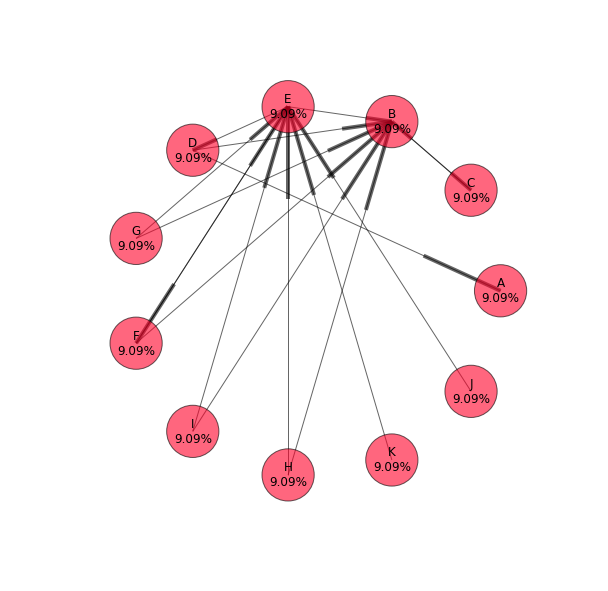

Teleportation:  0.75

Network graph for d =  0.25

Page Ranks for the nodes in perentage: {'A': 8.023259379473425, 'C': 10.888982020227372, 'B': 15.57705998764258, 'E': 14.14911041056024, 'D': 8.179486038217131, 'G': 7.000523225132273, 'F': 8.179486038217131, 'I': 7.000523225132273, 'H': 7.000523225132273, 'K': 7.000523225132273, 'J': 7.000523225132273}


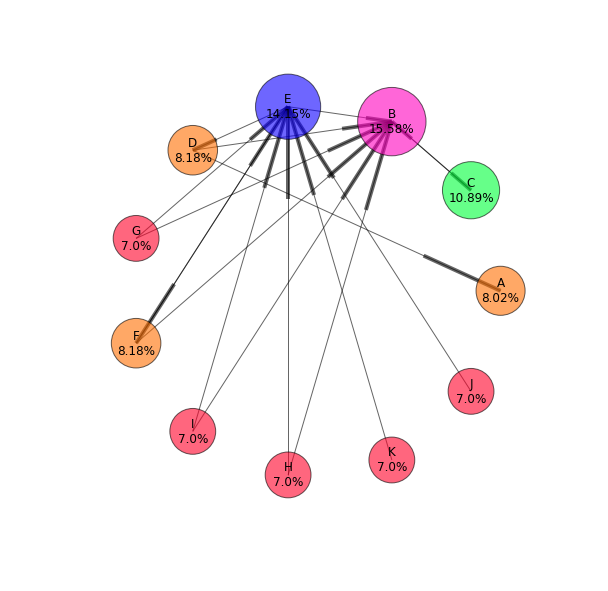

Teleportation:  0.5

Network graph for d =  0.5

Page Ranks for the nodes in perentage: {'A': 6.6947994530639185, 'C': 16.267535454093345, 'B': 22.846785380315147, 'E': 15.181899380956645, 'D': 7.380080783656721, 'G': 4.849763752851364, 'F': 7.380080783656721, 'I': 4.849763752851364, 'H': 4.849763752851364, 'K': 4.849763752851364, 'J': 4.849763752851364}


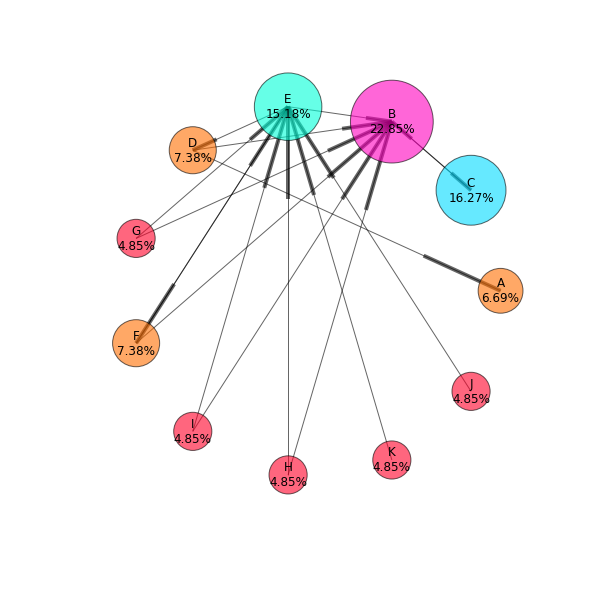

Teleportation:  0.25

Network graph for d =  0.75

Page Ranks for the nodes in perentage: {'A': 4.630146185613327, 'C': 27.24770205717453, 'B': 32.86609894880737, 'E': 11.424746230712731, 'D': 5.444605636743036, 'G': 2.5884190608411366, 'F': 5.444605636743036, 'I': 2.5884190608411366, 'H': 2.5884190608411366, 'K': 2.5884190608411366, 'J': 2.5884190608411366}


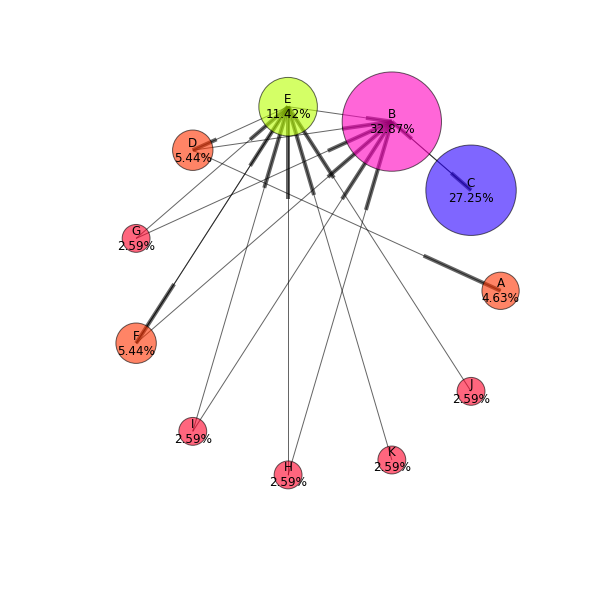

Teleportation:  0.15

Network graph for d =  0.85

Page Ranks for the nodes in perentage: {'A': 3.278149315962854, 'C': 34.2813061277085, 'B': 38.449817304323744, 'E': 8.088569323500208, 'D': 3.908709210026869, 'G': 1.6169479016901367, 'F': 3.908709210026869, 'I': 1.6169479016901367, 'H': 1.6169479016901367, 'K': 1.6169479016901367, 'J': 1.6169479016901367}


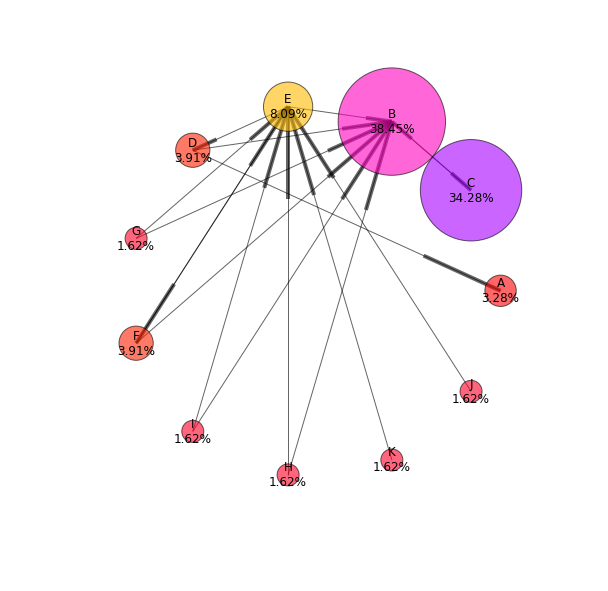

Teleportation:  0

Network graph for d =  1

Page Ranks for the nodes in perentage: {'A': 2.3244693608805884e-19, 'C': 61.46788990826225, 'B': 38.53211009174678, 'E': 4.165451853912407e-19, 'D': 2.524085924592612e-19, 'G': 3.3340237466545455e-20, 'F': 2.524085924592612e-19, 'I': 3.3340237466545455e-20, 'H': 3.3340237466545455e-20, 'K': 3.3340237466545455e-20, 'J': 3.3340237466545455e-20}


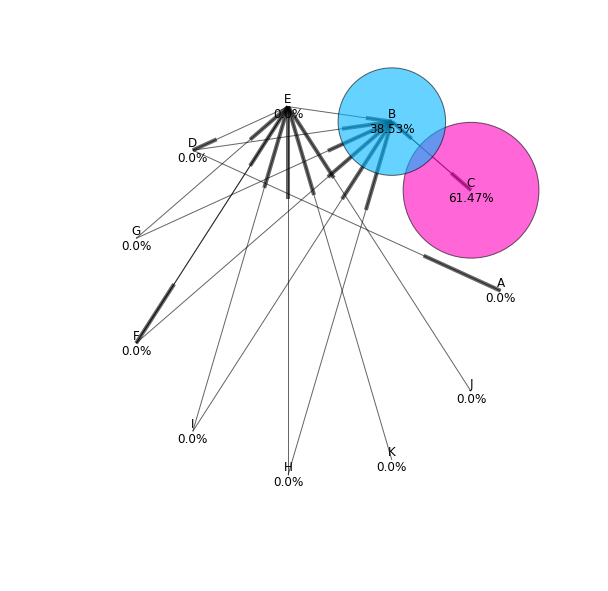

In [41]:
#driver for page rank so we can iterate in loop 

%reload_ext autoreload
%autoreload 2
from mrjob_pageRank import pageRank
from ast import literal_eval
import pprint
import networkx as nx
import matplotlib.pyplot as plt

input_file = 'PageRank-test.txt.out'


num_nodes = 11
damping_factor = [0,0.25,0.5,0.75, 0.85,1]
# damping_factor = [1]


for d in damping_factor:
    max_iteration = 100
    iter_num = 0
    teleporation = 0.0
    prev_ranks = []
    curr_ranks = []
    sum_partial_diff_PR = float('inf')
    teleporation = 1-d
    print "Teleportation: ",teleporation
    !python graph_eda.py PageRank-test.txt -q > PageRank-test.txt.out
    #loop till convergence
    while sum_partial_diff_PR > .0001 and iter_num < max_iteration:
        mr_job = pageRank(args=[input_file,
                                '--nodes','11',
                                '--teleportation',teleporation,
                                '--file', 'dangling_mass.txt',
                                '--no-strict-protocol'
                               ])

        with mr_job.make_runner() as runner: 
            runner.run()

            if iter_num == 0:
                prev_ranks = [0]*num_nodes
            else:
                prev_ranks = curr_ranks[:]
                del curr_ranks[:]



            with open(input_file, 'w') as f:
                for line in runner.stream_output():
                    f.write(line)
                    node,parsed_line = mr_job.parse_output_line(line)
                    tmp = literal_eval(str(parsed_line))
                    curr_ranks.append(round(float(tmp['*rank']),3))
                    total_page_rank += float(tmp['*rank'])


            sum_partial_diff_PR = sum([abs(x-y) for x,y in zip(curr_ranks, prev_ranks)])


#         print iter_num
        iter_num  += 1
    print "\nNetwork graph for d = ",d
    draw_graph(input_file)
    !rm PageRank-test.txt.out
    !rm dangling_mass.txt

### ===HW 9.3: Applying PageRank to the Wikipedia hyperlinks network===

Run your PageRank implementation on the Wikipedia dataset for 5 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Have the top 100 ranked pages changed? Comment on your findings. Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  




## With AWS modification 

In [49]:
!python -m mrjob.tools.emr.create_job_flow

using configs in /Users/hetal/.mrjob.conf
creating new scratch bucket mrjob-54e0b61edd1297ee
using s3://mrjob-54e0b61edd1297ee/tmp/ as our scratch dir on S3
Creating persistent job flow to run several jobs in...
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/no_script.hetal.20160315.003904.538330
writing master bootstrap script to /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/no_script.hetal.20160315.003904.538330/b.py
creating S3 bucket 'mrjob-54e0b61edd1297ee' to use as scratch space
Copying non-input files into s3://mrjob-54e0b61edd1297ee/tmp/no_script.hetal.20160315.003904.538330/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Can't access IAM API, trying default instance profile: EMR_EC2_DefaultRole
Can't access IAM API, trying default service role: EMR_DefaultRole
Job flow created with ID: j-1XQNMIP1915Z4
j-1XQNMIP1915Z4


In [ ]:
!aws s3 rm s3://hvcemrbucket/input/hw9/initial/ --recursive
!python graph_eda.py -r emr --no-output --pool-emr-job-flows --emr-job-flow-id j-V0YUQ1M76742 --output-dir s3://hvcemrbucket/input/hw9/initial/ s3://hvcemrbucket/input/hw7/all-pages-indexed-out.txt -q 

In [42]:
%%writefile mrjob_pageRank.py

from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
from ast import literal_eval
#used for AWS related read and write 
import boto
from boto.s3.key import Key
import sys

class pageRank(MRJob):
    dangling_mass = 0
    def steps(self):
        return [
            MRStep(mapper=self.mapper,reducer=self.reducer)
            ,MRStep(mapper_init=self.mapper_teleporation_init,mapper=self.mapper_dangling)
               ]
    
    def configure_options(self):
        super(pageRank, self).configure_options()
        self.add_passthrough_option(
            '--nodes',dest='N', type='int', default="1",
            help='Nodes: Total number of nodes in the graph')
        self.add_passthrough_option(
            '--teleportation',dest='alpha', type='float', default="0.15",
            help='Teleportation: Random jump factor to handle dangling nodes')
        self.add_passthrough_option(
            '--iteration',dest='iter_num', type='int', default="1",
            help='Iteration Number: Which iteration is going on')
        self.add_passthrough_option(
            '--mode',dest='mode', type='str', default="local",
            help='Mode: Which mode is the program running under:local, hadoop,emr')
        self.add_passthrough_option(
            '--aws_access_key_id',dest='aws_access_key_id', type='str', default="0",
            help='AWS Access Key')
        self.add_passthrough_option(
            '--aws_secret_access_key',dest='aws_secret_access_key', type='str', default="0",
            help='AWS Secret Key')
        
    def mapper(self,_,line):
        t = line.strip().split('\t')
        node = t[0]
        tmp_dict = literal_eval(t[1])
        neighbors= None
        if '*rank' in tmp_dict.keys():
            pr = float(tmp_dict['*rank'])
            del tmp_dict['*rank']
            neighbors = tmp_dict
        else :
            pr = 1/self.options.N # this is our first run and probability for each node is equal
            neighbors = tmp_dict
        yield node.replace("\"",""), ('{0}|{1}'.format('graph',neighbors))
        out_links =  len(neighbors)
        if (out_links != 0):
            for neighbor in neighbors:
                yield neighbor , pr/out_links
        else : yield 'dangling',pr
    
        
            
            
    def reducer(self,key,value):
        node = key
        valList = [val for val in value]
        graph_struct=None
        pr = 0
        if node == 'dangling': # code for summing up dangling mass . We wil write it to file 
            self.dangling_mass = sum(valList)
            if self.options.mode == 'local':
                with open('dangling_mass.txt', 'w') as f:
                    f.write('{0}'.format(self.dangling_mass))
                f.close()
            if self.options.mode == 'emr':
                try:
                    conn = boto.connect_s3(self.options.aws_access_key_id,self.options.aws_secret_access_key)
                    bucket = conn.get_bucket('hvcemrbucket')
                    k = Key(bucket)
                    k.key = 'input/hw9/dangling_mass/{0}'.format(self.options.iter_num) # Same as iteration
                    k.set_contents_from_string(str(self.dangling_mass))
                except boto.exception.S3ResponseError as err:
                    sys.stderr.write(err)
                    sys.exit(1)

        else: # code for summing up probability and yielding data out 
            for val in valList:
                if type(val)== str:
                    tmp = val.split('|')
                    graph_struct = literal_eval(tmp[1])
                else :
                    pr += val
            graph_struct['*rank'] = pr
            yield node,graph_struct
            
    def mapper_teleporation_init(self):
        self.dangling_mass = 0
        if self.options.mode =='local':
            try: #using try catch block here because if there are no dangling nodes than the 'dangling.txt' will not exist
                with open('dangling_mass.txt','r') as f:
                    l = f.readlines()
                    self.dangling_mass = float(l[0])
                open(dangling_mass.txt, 'w').close()
            except Exception as e: 
                pass
        if self.options.mode =='emr':
            try:
                conn = boto.connect_s3(self.options.aws_access_key_id,self.options.aws_secret_access_key)
                bucket = conn.get_bucket('hvcemrbucket') # substitute your bucket name here
                k = Key(bucket)
                k.key = 'input/hw9/dangling_mass/{0}'.format(self.options.iter_num)
                self.dangling_mass = float(k.get_contents_as_string())
            except boto.exception.S3ResponseError as err:
                sys.stderr.write(err)
                sys.exit(1)
#         print "From second map reduce job",self.dangling_mass
    
    def mapper_dangling(self,key,value):
        node = key.replace("\"","")
        graph_struct = literal_eval(str(value))
        pr = float(value['*rank'])
        new_pr = 0
        if(self.dangling_mass > 0):
            new_pr = (self.options.alpha/self.options.N)+(1-self.options.alpha)*((self.dangling_mass/self.options.N)+pr)
        else: new_pr = pr
        graph_struct['*rank'] = new_pr
        yield node,graph_struct
if __name__ == '__main__':
    pageRank.run()    

Overwriting mrjob_pageRank.py


In [17]:
%reload_ext autoreload
%autoreload 2
from mrjob_pageRank import pageRank

In [58]:
%%writefile run_pageRank.py

from mrjob_pageRank import pageRank
from ast import literal_eval
import sys

# !python graph_eda.py PageRank-test.txt -q > PageRank-test.txt.out

input_file = 'PageRank-test.txt.out'

aws_creds = {}
with open("/Users/hetal/.aws/credentials", "r") as f:
    for l in f:
        if l.startswith('aws'):
            t = l.split('=')
            aws_creds[t[0].strip()] = t[1].strip()

if len(sys.argv) == 4: 
    max_iterations = int(sys.argv[1])
    cluster_id = sys.argv[3]
    mode = sys.argv[2]
else:
    print "Invalid arguments."
    sys.exit(-1)

print 'Cluster Id',cluster_id
print 'max iterations',max_iterations
print 'Mode',mode

iter_num = 0
# max_iterations = 5
# we are taking this number from the HW7 wikipedia exploratory data analysis
num_nodes = 15192277
teleporation = 0.15

prev_ranks = []
curr_ranks = []
sum_partial_diff_PR = float('inf')

# mode ='emr'
s3_source = 's3://hvcemrbucket/input/hw7/all-pages-indexed-out.txt'
s3_path = 's3://hvcemrbucket/input/inter_input/wiki'

# After so many iterations (TBD: Convergence Criteria)
while iter_num < max_iterations:
    
    print "\n\nIteration: ",iter_num
    
    if mode=='emr':
        if iter_num == 0:  #first iteration we want to use the original source
            s3_source = 's3://hvcemrbucket/input/hw9/initial/'
        else:  #after first iteration, we want to use the files created from previous iteration
            s3_source = s3_path + "_" + str(iter_num-1) + "/"

        #this will be the new location for files created
        s3_target = s3_path + "_"  + str(iter_num) + "/"

    #setup mr job configuration
    mr_job = pageRank(args=[s3_source,
                            '-r','emr',
                            '--no-strict-protocol',
                            '--nodes','{0}'.format(num_nodes),
                            '--mode','emr',
                            '--teleportation','{0}'.format(teleporation),
                            '--iteration','{0}'.format(iter_num),
                            '--emr-job-flow-id',cluster_id,
                            '--output-dir',s3_target,
                            '--aws_access_key_id','{0}'.format(aws_creds['aws_access_key_id']),
                            '--aws_secret_access_key','{0}'.format(aws_creds['aws_secret_access_key'])
                           ])
    
    with mr_job.make_runner() as runner: 
        runner.run()    
    iter_num  += 1

Overwriting run_pageRank.py


In [34]:
!aws s3 rm s3://hvcemrbucket/input/hw9/dangling_mass/ --recursive
!aws s3 rm s3://hvcemrbucket/input/inter_input/ --recursive
!python run_pageRank.py



Iteration:  0
No handlers could be found for logger "mrjob.conf"


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


In [53]:
#clean up aws
!aws s3 rm s3://hvcemrbucket/input/hw9/dangling_mass/ --recursive
!aws s3 rm s3://hvcemrbucket/input/inter_input/ --recursive

In [59]:
!python run_pageRank.py 10 emr 'j-1XQNMIP1915Z4'

Cluster Id j-1XQNMIP1915Z4
max iterations 10
Mode emr


Iteration:  0
No handlers could be found for logger "mrjob.conf"


Iteration:  1


Iteration:  2


Iteration:  3


Iteration:  4


Iteration:  5


Iteration:  6


Iteration:  7


Iteration:  8


Iteration:  9


In [114]:
%%writefile pageRank_analysis.py

from __future__ import division
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.compat import get_jobconf_value
from ast import literal_eval
import heapq

#we have used heapq here so we can remove the smallest element if the queue is full during insertion.
def add_to_max_Q(max_q,node,score,n_max):
    # add elements if q is not full
    if (len(max_q) < n_max):
        heapq.heappush(max_q, (score, node))
    else:
        # add new element and then remove smallest element
        heapq.heappush(max_q, (score, node))
        heapq.heappop(max_q)

#function to print the queue data
def print_topn(max_q,n_max):
    cnt = len(max_q)
    if(cnt > n_max):
        cnt = n_max
    s = heapq.nlargest(cnt, max_q)
    for row in s:
        print '%s\t%s'%(row[1] ,row[0])


class pageRank_Analysis(MRJob):
    q_max = []
    r_cnt = 0
    def steps(self):
        return [
            MRStep(mapper=self.mapper,mapper_final=self.mapper_final,reducer=self.reducer,
                  jobconf={
                            'mapred.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                            'mapred.text.key.comparator.options': '-k1,1nr',
                            'mapred.reduce.tasks':1
                            }
                  )
               ]
    
    def configure_options(self):
        super(pageRank_Analysis, self).configure_options()
        self.add_passthrough_option(
            '--topN',dest='topN', type='int', default="10",
            help='Nodes: Total number of nodes in the graph')
    
    def mapper_init(self):
        self.q_max=[]
        
    def mapper(self,_,line):
        t = line.strip().split('\t')
        node = t[0]
        tmp_dict = literal_eval(t[1])
        score = tmp_dict['*rank']*100
        add_to_max_Q(self.q_max,node.replace("\"",""),score,self.options.topN)
       
 
    def mapper_final(self):
        cnt = len(self.q_max)
        if(cnt > self.options.topN):
            cnt = self.options.topN
        s = heapq.nlargest(cnt, self.q_max)
        for row in s:
            yield row[0] ,row[1]
               
            
    def reducer(self,key,value):
        if (self.r_cnt < self.options.topN):
            yield list(value)[0], key
        self.r_cnt+=1
            
if __name__ == '__main__':
    pageRank_Analysis.run()    

Overwriting pageRank_analysis.py


In [110]:
!python pageRank_analysis.py --topN 2 PageRank-test.txt.out -q

"C"	34.2813061277085
"B"	38.44981730432374


In [115]:
!python pageRank_analysis.py -r emr --no-output --emr-job-flow-id j-1XQNMIP1915Z4 \
--topN 100 \
--output-dir s3://hvcemrbucket/output/hw9/wiki5/ \
s3://hvcemrbucket/input/wiki5/wiki_4/

Got unexpected keyword arguments: ssh_tunnel
using configs in /Users/hetal/.mrjob.conf
using existing scratch bucket mrjob-54e0b61edd1297ee
using s3://mrjob-54e0b61edd1297ee/tmp/ as our scratch dir on S3
creating tmp directory /var/folders/91/cjfxt7ys6958qll6vjtgwwfw0000gn/T/pageRank_analysis.hetal.20160315.042159.788841
Copying non-input files into s3://mrjob-54e0b61edd1297ee/tmp/pageRank_analysis.hetal.20160315.042159.788841/files/
Adding our job to existing job flow j-1XQNMIP1915Z4
Job launched 31.1s ago, status WAITING: Cluster ready after last step completed.
Job launched 62.6s ago, status RUNNING: Running step (pageRank_analysis.hetal.20160315.042159.788841: Step 1 of 1)
Job launched 93.7s ago, status RUNNING: Running step (pageRank_analysis.hetal.20160315.042159.788841: Step 1 of 1)
Job launched 125.2s ago, status RUNNING: Running step (pageRank_analysis.hetal.20160315.042159.788841: Step 1 of 1)
Job launched 156.3s ago, status RUNNING: Running step (pageRank_analysis.hetal.2016

In [116]:
#run job for wiki 10 iterations
!python pageRank_analysis.py -r emr --no-output --emr-job-flow-id j-1XQNMIP1915Z4 \
--topN 100 \
--output-dir s3://hvcemrbucket/output/hw9/wiki10/ \
s3://hvcemrbucket/input/inter_input/wiki_9/ -q

In [118]:
!aws s3 cp s3://hvcemrbucket/output/hw9/wiki5/part-00000  ./wiki5.out
!aws s3 cp s3://hvcemrbucket/output/hw9/wiki10/part-00000  ./wiki10.out

download: s3://hvcemrbucket/output/hw9/wiki5/part-00000 to ./wiki5.out
download: s3://hvcemrbucket/output/hw9/wiki10/part-00000 to ./wiki10.out


In [121]:
print "\nTop 10 scores in percentage from running 5 iterations"
print " Node             Score"
!head -10 wiki5.out
print "\nTop 10 scores in percentage from running 10 iterations"
print " Node             Score"
!head -10 wiki10.out


Top 10 scores in percentage from running 5 iterations
 Node             Score
"13455888"	0.14607248568232181
"1184351"	0.068282809653114576
"4695850"	0.064298074385332582
"5051368"	0.057637936353319694
"1384888"	0.046003296218331498
"7902219"	0.045813314331971222
"6113490"	0.045473147756772872
"2437837"	0.044562508250768518
"6076759"	0.043040419620365172
"13425865"	0.042865182357834555

Top 10 scores in percentage from running 10 iterations
 Node             Score
"13455888"	0.14614491944098285
"1184351"	0.066633173766347059
"4695850"	0.063980518762471433
"5051368"	0.057485388269496854
"1384888"	0.045030471433575192
"2437837"	0.044660099103954819
"6113490"	0.044481824807304053
"7902219"	0.044420373464935638
"13425865"	0.043299524497370331
"6076759"	0.042788533618118345


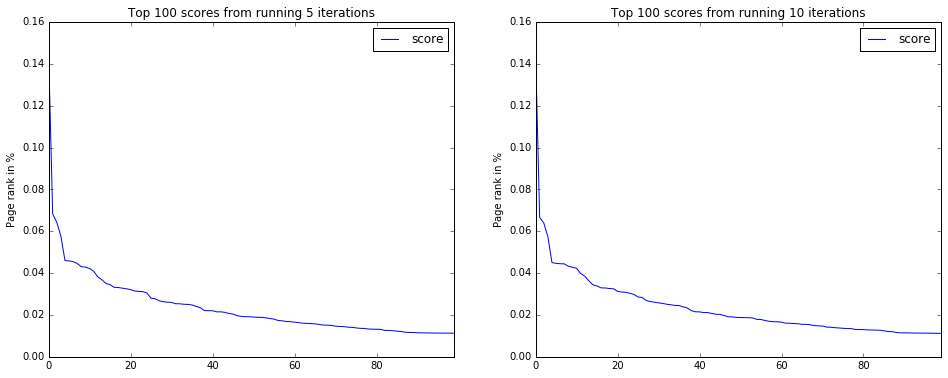

In [130]:
#plot degree of distribution
import pandas as pd
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
df1 = pd.read_csv('wiki5.out',sep='\t',header=None)
df1.columns = ['nodes','score']
df1.plot(kind='line',y='score',ax=ax)
plt.ylabel('Page rank in %')
plt.title('Top 100 scores from running 5 iterations')
ax = fig.add_subplot(122)
df1 = pd.read_csv('wiki10.out',sep='\t',header=None)
df1.columns = ['nodes','score']
df1.plot(kind='line',y='score',ax=ax)
plt.ylabel('Page rank in %')
plt.title('Top 100 scores from running 10 iterations')



### ===HW 9.4: Topic-specific PageRank implementation using MRJob===

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

and must be adhered to for convergence to be guaranteed.

Run topic specific PageRank on the following randomly generated network of 100 nodes:

s3://ucb-mids-mls-networks/randNet.txt (also available on Dropbox)

which are organized into ten topics, as described in the file:

s3://ucb-mids-mls-networks/randNet_topics.txt  (also available on Dropbox)

Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.

One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

vji = beta*(1/|Tj|); if node i lies in topic Tj

vji = (1-beta)*(1/(N - |Tj|)); if node i lies outside of topic Tj

for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

### ===HW 9.5: Applying topic-specific PageRank to Wikipedia===

Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10,
so that there are 10 topics. Once again, print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.



### HW 9.6: TextRank (OPTIONAL)

What is TextRank. Describe the main steps in the algorithm. Why does TextRank work?
Implement TextRank in MrJob for keyword phrases (not just unigrams) extraction using co-occurrence based similarity measure with with sizes of N = 2 and 3. And evaluate your code using the following example using precision, recall, and FBeta (Beta=1):

"Compatibility of systems of linear constraints over the set of natural numbers
Criteria of compatibility of a system of linear Diophantine equations, strict 
inequations, and nonstrict inequations are considered. Upper bounds for
components of a minimal set of solutions and algorithms of construction of 
minimal generating sets of solutions for all types of systems are given. 
These criteria and the corresponding algorithms for constructing a minimal 
supporting set of solutions can be used in solving all the considered types of 
systems and systems of mixed types." 

The extracted keywords should in the following set:

linear constraints, linear diophantine equations, natural numbers, non-strict inequations, strict inequations, upper bounds



In [ ]:
aws_creds = {}
with open("/Users/hetal/.aws/credentials", "r") as f:
    for l in f:
        if l.startswith('aws'):
            t = l.split('=')
            aws_creds[t[0].strip()] = t[1].strip()



In [ ]:
# Print out bucket names
for bucket in s3.buckets.all():
    print(bucket.name)

In [ ]:
#writing data to s3
import boto
from boto.s3.key import Key
conn = boto.connect_s3(aws_creds['aws_access_key_id'],aws_creds['aws_secret_access_key'])
bucket = conn.get_bucket('hvcemrbucket')
print bucket
k = Key(bucket)
print k
k.key = 'input/hw9/dangling_mass/1' # Same as iteration
k.set_contents_from_string(str(0.09))
# except boto.exception.S3ResponseError as err:
# sys.stderr.write(err)
# sys.exit(1)

In [ ]:
#reading contents of file 
import boto
c = boto.connect_s3()
b = c.get_bucket('hvcemrbucket') # substitute your bucket name here
from boto.s3.key import Key
k = Key(b)
k.key = 'input/dangling_mass/0'
a = float(k.get_contents_as_string())
print a
